In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.image as mpimg

In [54]:
# File loading

DIR = "/content/drive/MyDrive/ML_project/data/fungi_train_val"
directories = []

folders = os.listdir(DIR)

for folder in folders:
    photos = os.listdir(DIR + "/" + folder)
    cat = ' '.join(folder.split('_')[1:])
    super_cat = folder.split('_')[1]
    for photo in photos:
        path = DIR + "/" + folder + "/" + photo
        directories.append({
            'super_category': super_cat, 
            'category': cat, 
            'path': path
        })
        
df = pd.DataFrame(directories)
print("Images: " + str(len(df.index)) + ", classes: " + str(len(df.groupby(['category']).count())) + ", super classes: " + str(len(df.groupby(['super_category']).count())))

Images: 6739, classes: 20, super classes: 19


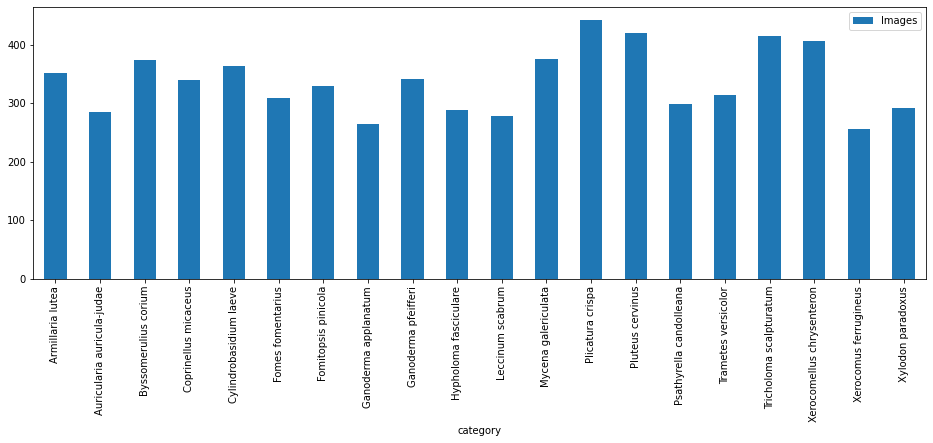

In [55]:
df_grouped = df.groupby(['category']).count().rename(columns={'path':'count'})[['count']]
fig, ax = plt.subplots()
df_grouped.plot(ax=ax, kind='bar', figsize=(16,5))
ax.legend(["Images"])
plt.show()

df_sorted = df_grouped.sort_values(by='count', ascending=False)

In [85]:
MOBILENET_V2 = 'mobilenetv2'
XCEPTION = 'xception'

# Global parameters

MODEL = XCEPTION
N_CLASSES = 3
SAMPLES_PER_CLASS = 414
TRAINING_SIZE_RATIO = 0.8
VALIDATION_SIZE_RATIO = 0.2
if MODEL == MOBILENET_V2:
  IMG_SIZE = (224, 224)
else:
  IMG_SIZE = (299, 299)
BATCH_SIZE = 32             # if None is 32 (default)
LEARNING_RATE = 0.0001
PATIENCE = 10

In [86]:
reference = 'category'

classes = df[reference].drop_duplicates()
df1 = pd.DataFrame()
for i, v in df_sorted.iloc[:N_CLASSES].iterrows():
    size = min(SAMPLES_PER_CLASS, df.loc[df[reference] == i].shape[0])
    training_size = int(size*TRAINING_SIZE_RATIO)
    validation_size = int(training_size*VALIDATION_SIZE_RATIO)

    tmp_df = df.loc[df[reference] == i].iloc[:training_size-validation_size]
    tmp_df['split'] = 'train'
    df1 = df1.append(tmp_df)

    tmp_df = df.loc[df[reference] == i].iloc[training_size-validation_size:training_size]
    tmp_df['split'] = 'val'
    df1 = df1.append(tmp_df)

    tmp_df = df.loc[df[reference] == i].iloc[training_size:SAMPLES_PER_CLASS]
    tmp_df['split'] = 'test'
    df1 = df1.append(tmp_df)

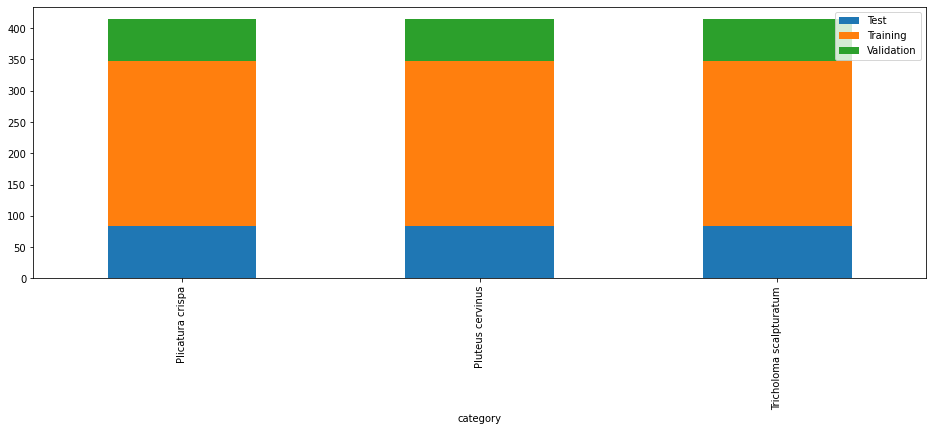

count          
split                    test train val
category                               
Plicatura crispa           83   265  66
Pluteus cervinus           83   265  66
Tricholoma scalpturatum    83   265  66

In [87]:
df_count = df1.groupby(['category','split']).count().rename(columns={'path':'count'})[['count']]
df_count = df_count.unstack('split')
fig, ax = plt.subplots()
df_count.plot(kind='bar', ax=ax, stacked=True, figsize=(16,5))
ax.legend(["Test", "Training", "Validation"])
plt.show()

df_count

In [88]:
df_training = df1.loc[df1['split'] == 'train']
df_validation = df1.loc[df1['split'] == 'val']
df_test = df1.loc[df1['split'] == 'test']

print("Training set:", df_training.shape[0])
print("Validation set:", df_validation.shape[0])
print("Test set:", df_test.shape[0])

Training set: 795
Validation set: 198
Test set: 249


In [89]:
DIR = os.getcwd()

training_datagen = ImageDataGenerator()

train_generator = training_datagen.flow_from_dataframe(
    df_training,
    DIR,
    'path',
    'category',
    target_size=(IMG_SIZE),
    class_mode='categorical'
)

Found 795 validated image filenames belonging to 3 classes.


In [90]:
validation_datagen = ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    df_validation,
    DIR,
    'path',
    'category',
    target_size=(IMG_SIZE),
    class_mode='categorical'
)

Found 198 validated image filenames belonging to 3 classes.


In [91]:
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    df_test,
    DIR,
    'path',
    'category',
    target_size=(IMG_SIZE),
    class_mode='categorical',
    shuffle=False
)

Found 249 validated image filenames belonging to 3 classes.


In [92]:
classes = []

for i in train_generator.class_indices:
    classes.append(i)

In [93]:
# From https://www.tensorflow.org/tutorials/images/transfer_learning

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [94]:
IMG_SHAPE = IMG_SIZE + (3,)

if MODEL == MOBILENET_V2:
  base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
  preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
else:
  base_model = tf.keras.applications.Xception(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
  preprocess_input = tf.keras.applications.xception.preprocess_input

In [95]:
base_model.trainable = False

In [96]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(units=N_CLASSES, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [97]:
for layer in model.layers:
    print(layer.name, layer.trainable)

input_6 True
sequential_2 True
tf.math.truediv_2 True
tf.math.subtract_2 True
xception False
global_average_pooling2d_2 True
dropout_2 True
dense_2 True


In [98]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.subtract_2 (TFOpLamb (None, 299, 299, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0   

In [99]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE),
              metrics=['accuracy','top_k_categorical_accuracy'])

In [100]:
def elapsed_time(start_time):
    delta = time.time()-start_time
    hours = int(delta/(60*60))
    delta -= hours*(60*60)
    minut = int(delta/60)
    delta -= minut*60
    sec = int(delta)
    return (hours, minut, sec)

In [101]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=PATIENCE)

checkpoint_filepath = '/tmp/checkpoint'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

start_time = time.time()

history = model.fit(train_generator, epochs=100, batch_size=BATCH_SIZE,
            validation_data = validation_generator,
            verbose=1, callbacks=[early_stopping])

training_time = elapsed_time(start_time)
print("Elapsed time: %ih %im %is" % training_time)

#model.load_weights(checkpoint_filepath)
#model.save('/content/drive/MyDrive/ML_project/model.h5')

Epoch 1/100
25/25 [==============================] - 18s 605ms/step - loss: 1.1338 - accuracy: 0.3689 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.0344 - val_accuracy: 0.5253 - val_top_k_categorical_accuracy: 1.0000
Epoch 2/100
25/25 [==============================] - 13s 535ms/step - loss: 1.0335 - accuracy: 0.5095 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.9643 - val_accuracy: 0.6869 - val_top_k_categorical_accuracy: 1.0000
Epoch 3/100
25/25 [==============================] - 13s 526ms/step - loss: 0.9585 - accuracy: 0.6207 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.9065 - val_accuracy: 0.7273 - val_top_k_categorical_accuracy: 1.0000
Epoch 4/100
25/25 [==============================] - 13s 526ms/step - loss: 0.8990 - accuracy: 0.6566 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.8546 - val_accuracy: 0.7677 - val_top_k_categorical_accuracy: 1.0000
Epoch 5/100
25/25 [==============================] - 13s 526ms/step - loss: 0.8403 - accuracy: 0.7309 - top_k_ca

In [102]:
def plot_learning_curves(history, history_fine=False):

  if history_fine:
    acc = history.history['accuracy'] + history_fine.history['accuracy']
    val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
    loss = history.history['loss'] + history_fine.history['loss']
    val_loss = history.history['val_loss'] + history_fine.history['val_loss']
    start_fine_tuning = len(history.history['accuracy'])
  else:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']


  fig, axes = plt.subplots(1, 2, figsize=(16,5))

  # summarize history for accuracy
  axes[0].plot(acc, label='Training Accuracy')
  axes[0].plot(val_acc, label='Validation Accuracy')
  if history_fine:
    axes[0].plot([start_fine_tuning-1, start_fine_tuning-1], plt.ylim(), label='Start Fine Tuning')
  axes[0].set_title('Model accuracy')
  axes[0].set_ylabel('Accuracy')
  axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
  axes[0].set_xlabel('Epoch')
  axes[0].legend(loc='lower right')

  # summarize history for loss
  axes[1].plot(loss, label='Training Loss')
  axes[1].plot(val_loss, label='Validation Loss')
  if history_fine:
    axes[1].plot([start_fine_tuning-1, start_fine_tuning-1], plt.ylim(), label='Start Fine Tuning')
  axes[1].set_title('Model loss')
  axes[1].set_ylabel('Loss')
  axes[1].set_xlabel('Epoch')
  axes[1].legend(loc='upper right')

  plt.show()

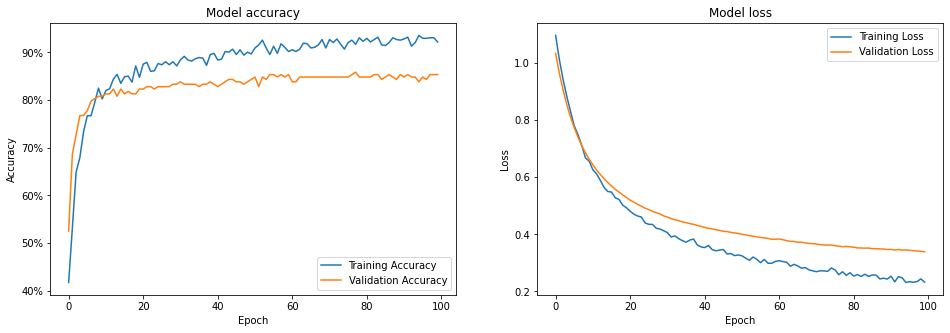

In [103]:
plot_learning_curves(history)

In [104]:
test_loss, test_acc, _ = model.evaluate(test_generator)

8/8 [==============================] - 4s 498ms/step - loss: 0.2944 - accuracy: 0.8876 - top_k_categorical_accuracy: 1.0000


In [105]:
def print_classification_report_and_confusion_matrix():
  #Confution Matrix and Classification Report
  Y_pred = model.predict(test_generator, df_test.shape[0] // BATCH_SIZE+1)
  y_pred = np.argmax(Y_pred, axis=1)

  print('Classification Report')
  print(classification_report(test_generator.classes, y_pred, target_names=classes))

  df_cm = pd.DataFrame(confusion_matrix(test_generator.classes, y_pred), 
                      index = [i for i in classes],
                      columns = [i for i in classes])
  plt = sn.heatmap(df_cm, annot=True, cmap="Blues")
  plt.set_ylabel("Real") 
  plt.set_xlabel("Predicted")
  plt.set_xticklabels(plt.get_xticklabels(), rotation=-30, ha="left") 

Classification Report
                         precision    recall  f1-score   support

       Plicatura crispa       0.98      0.96      0.97        83
       Pluteus cervinus       0.82      0.84      0.83        83
Tricholoma scalpturatum       0.87      0.86      0.86        83

               accuracy                           0.89       249
              macro avg       0.89      0.89      0.89       249
           weighted avg       0.89      0.89      0.89       249



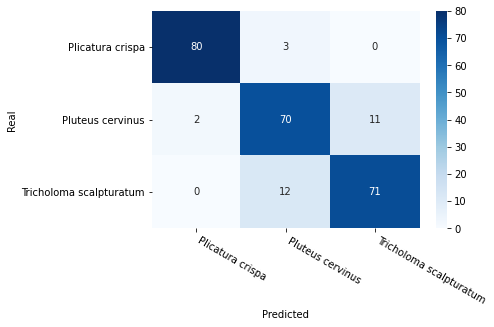

In [106]:
print_classification_report_and_confusion_matrix()

In [107]:
# Fine tuning

base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  132


In [108]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE/10),
              metrics=['accuracy', 'top_k_categorical_accuracy'])

In [109]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.subtract_2 (TFOpLamb (None, 299, 299, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0   

In [110]:
start_time = time.time()

history_fine = model.fit(train_generator, 
                    epochs=len(history.history['accuracy']) + 20,
                    initial_epoch=history.epoch[-1],
                    batch_size=BATCH_SIZE,
                    validation_data = validation_generator,
                    verbose=1, 
                    callbacks=[early_stopping])

training_time = elapsed_time(start_time)
print("\nElapsed time: %ih %im %is" % training_time)

Epoch 100/120
25/25 [==============================] - 19s 616ms/step - loss: 0.4186 - accuracy: 0.8450 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.3190 - val_accuracy: 0.8586 - val_top_k_categorical_accuracy: 1.0000
Epoch 101/120
25/25 [==============================] - 14s 563ms/step - loss: 0.3816 - accuracy: 0.8654 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.3113 - val_accuracy: 0.8485 - val_top_k_categorical_accuracy: 1.0000
Epoch 102/120
25/25 [==============================] - 14s 568ms/step - loss: 0.3470 - accuracy: 0.8757 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.3456 - val_accuracy: 0.8535 - val_top_k_categorical_accuracy: 1.0000
Epoch 103/120
25/25 [==============================] - 14s 569ms/step - loss: 0.2936 - accuracy: 0.8971 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.3786 - val_accuracy: 0.8131 - val_top_k_categorical_accuracy: 1.0000
Epoch 104/120
25/25 [==============================] - 14s 567ms/step - loss: 0.2163 - accuracy: 0.9457 

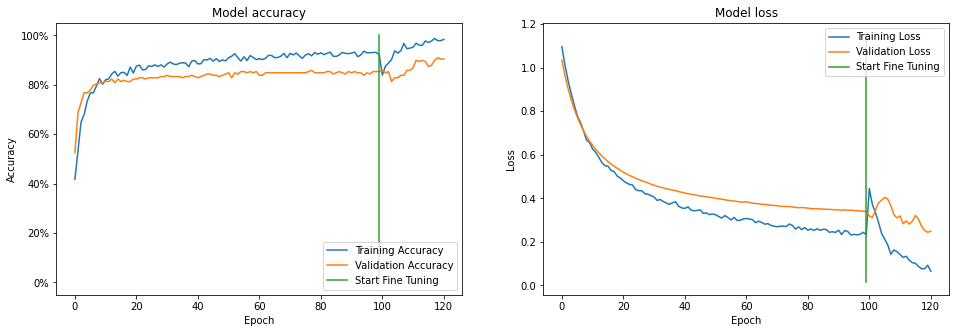

In [111]:
plot_learning_curves(history, history_fine)

In [112]:
test_loss, test_acc, _ = model.evaluate(test_generator)

8/8 [==============================] - 4s 427ms/step - loss: 0.2415 - accuracy: 0.8916 - top_k_categorical_accuracy: 1.0000


Classification Report
                         precision    recall  f1-score   support

       Plicatura crispa       0.98      0.95      0.96        83
       Pluteus cervinus       0.79      0.92      0.85        83
Tricholoma scalpturatum       0.93      0.81      0.86        83

               accuracy                           0.89       249
              macro avg       0.90      0.89      0.89       249
           weighted avg       0.90      0.89      0.89       249



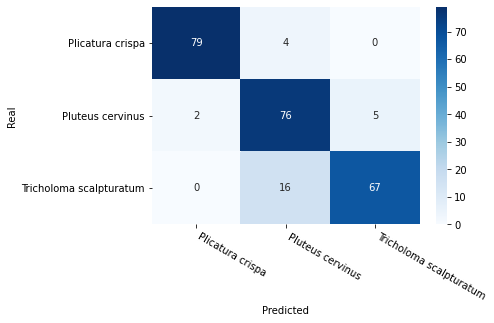

In [113]:
print_classification_report_and_confusion_matrix()

Found 60 validated image filenames belonging to 3 classes.


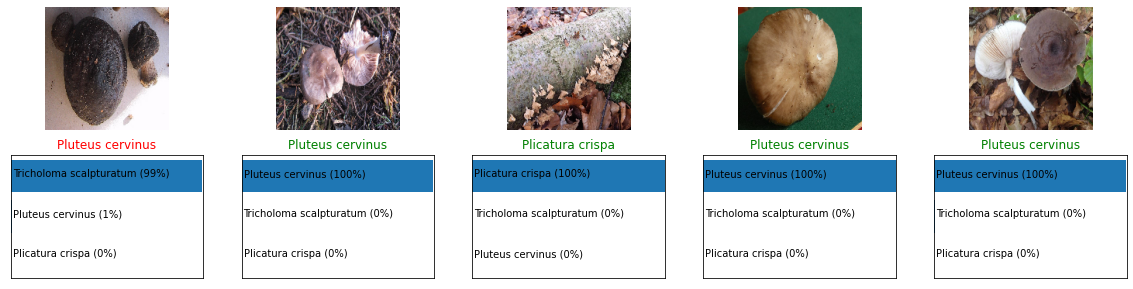

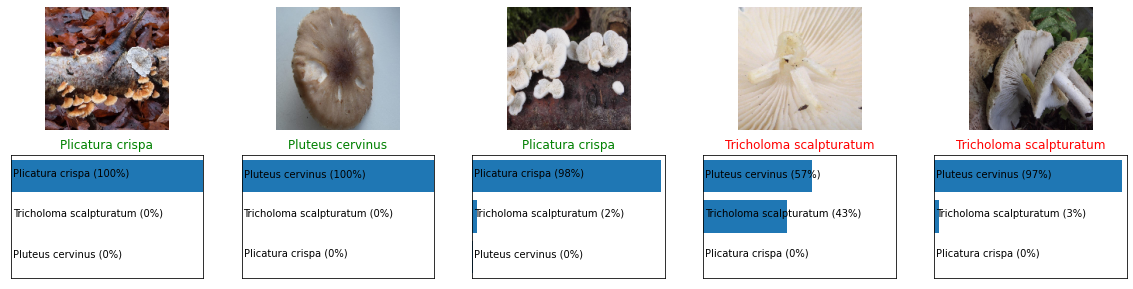

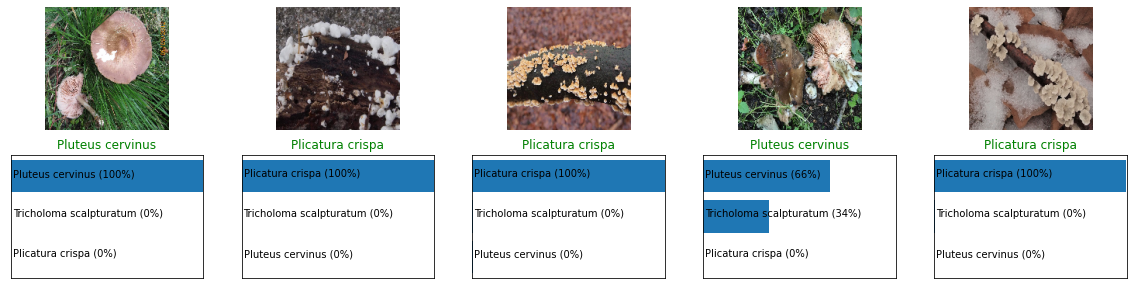

In [67]:
# Making some random predicions

# Shuffle the generator to obtain random images
test_generator = test_datagen.flow_from_dataframe(
    df_test,
    DIR,
    'path',
    'category',
    target_size=(IMG_SIZE),
    class_mode='categorical'
)

iters = 0
n_predictions = 12
n_cols = 5
    
for i, batch in enumerate(test_generator):
    if iters > n_predictions:
        break
    
    batch_images, batch_labels = batch
    
    for j in range(len(batch_images)):
        if iters > n_predictions:
            break
            
        fig, axes = plt.subplots(2, n_cols, figsize=(20,5))
        
        for k in range(n_cols):
            prediction = model.predict(np.array([batch_images[j*n_cols+k]]))
            res = [{'label': classes[h], 'val': prediction[0][h]} for h in range(len(classes))]
            res.sort(key=lambda x: x['val'], reverse=True)
            res = res[0:5]
            axes[0][k].imshow(batch_images[j*n_cols+k].astype(np.uint8))
            axes[0][k].grid(False)
            axes[0][k].axis('off')
            title_color = 'green'
            if np.argmax(batch_labels[j*n_cols+k]) != np.argmax(prediction[0]):
                title_color = 'red'
            axes[1][k].set_title(classes[np.argmax(batch_labels[j*n_cols+k])], color=title_color)
            axes[1][k].barh([x['label'] for x in res], [x['val'] for x in res])
            axes[1][k].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
            axes[1][k].set_xlim(0, 1)
            axes[1][k].invert_yaxis()
            axes[1][k].set_xticks([])
            axes[1][k].set_yticks([])
            for h, v in enumerate(res):
                axes[1][k].text(0.01, h, '{} ({:.0%})'.format(v['label'], v['val']))
                
            iters += 1

        plt.show()